# Test over Synthetic Data

We will generate 1000 data points. Each data point will contain 150 predictors ($X_i = x_{i1}, x_{i2}, \dots, x_{i150}$) and the response of the system ($y_i$). To generate the random data points $X=<X_1, X_2, \dots, X_{1000}>$, we sample a thousand times from the binomial distribution with $n=150$ and $p=0.5$.

Let's first import the necessary modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import main_np as main

To generate $X$, we will use a simply `numpy` trick.

In [2]:
X = np.random.rand(1000, 70)
X = np.round(X)
X

array([[1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 1.]])

Now that we have $X$, it's time to generate our synthetic system's response $Y$. To do that, first we'll need to identify the noisy function of actual predictors according to which response is made. Since our statistical method works for sparse models, we say that this underlying function depends only on the following 7 predictors out of 150 predictors:
                $$<x_{13}, x_{31}, x_{38}, x_{55}>$$

We'll represent this function by $F: \{0,1\}^7 \rightarrow \mathbb{Z}_{3} $, where $\mathbb{Z}_{3} = \{0, 1, 2\}$.

We have a generated boolean function stored as a csv. Lets load it.

In [3]:
df = pd.read_csv("data/bool_func.csv", index_col=0)
df

,x55,x38,x31,x13,y0,y1,y2
0,0.0,0.0,0.0,0.0,7.715613e-01,4.817829e-10,2.284387e-01
1,0.0,0.0,0.0,1.0,2.581223e-04,9.997419e-01,1.238610e-21
2,0.0,0.0,1.0,0.0,9.999999e-01,7.076523e-08,2.697647e-08
3,0.0,0.0,1.0,1.0,9.032021e-01,1.337596e-14,9.679786e-02
4,0.0,1.0,0.0,0.0,9.925948e-01,4.670690e-03,2.734479e-03
5,0.0,1.0,0.0,1.0,8.782210e-01,6.807604e-42,1.217790e-01
6,0.0,1.0,1.0,0.0,1.298939e-11,1.000000e+00,7.649856e-39
7,0.0,1.0,1.0,1.0,9.986412e-01,5.024311e-07,1.358252e-03
8,1.0,0.0,0.0,0.0,3.150446e-04,9.996850e-01,1.792178e-25
9,1.0,0.0,0.0,1.0,2.755406e-26,1.000000e+00,1.799499e-17


In [4]:
def bool_func(xi):
    """Takes an index/row of truth table and returns the response 
    according to the boolean function"""
    if isinstance(xi, int):
        weight_arr = df.iloc[xi, 4:].values
    else:
        bool_arr = np.all(df.iloc[:, :4].values == xi, axis=1)
        weight_arr = df.iloc[bool_arr, 4:].iloc[0].values
    return np.random.choice(3, p=weight_arr)

With `bool_func` we can start generating responses of our synthetic system. The response depends only on actual predictors of the system.

In [5]:
X_actual = X[:, [55, 38, 31, 13]]
X_actual.shape

(1000, 4)

In [6]:
Y = np.apply_along_axis(bool_func, axis=1, arr=X_actual)
Y.shape

(1000,)

Now we have all we need. Let's see if our statistical method could predict which predictors does the response depends upon.

In [7]:
x = main.metropolis(X, Y, X.shape[1], 3, it=20000)

0 took 3.337860107421875e-06 seconds
500 took 46.75460433959961 seconds
1000 took 37.395715951919556 seconds
1500 took 32.70097351074219 seconds
2000 took 48.85024952888489 seconds
2500 took 42.249069690704346 seconds
3000 took 40.01210045814514 seconds
3500 took 38.79059028625488 seconds
4000 took 40.37390875816345 seconds
4500 took 40.65480136871338 seconds
5000 took 40.842244148254395 seconds
5500 took 37.06320905685425 seconds
6000 took 36.84431576728821 seconds
6500 took 43.60310482978821 seconds
7000 took 42.912097454071045 seconds
7500 took 41.40037441253662 seconds
8000 took 40.631919384002686 seconds
8500 took 40.629234075546265 seconds
9000 took 41.00393462181091 seconds
9500 took 42.051544427871704 seconds
10000 took 41.84507775306702 seconds
10500 took 41.427485942840576 seconds
11000 took 40.29946827888489 seconds
11500 took 41.496033668518066 seconds
12000 took 42.00864124298096 seconds
12500 took 41.99349355697632 seconds
13000 took 42.103562355041504 seconds
13500 took 

In [8]:
pd.DataFrame(x).to_csv("data/mcmc-1.csv")
pd.DataFrame(x).to_excel("data/mcmc-1.xlsx")

In [9]:
plt.ioff() # turn off interactive mode

In [12]:
data = np.array(x)
data.shape

(20001, 70)

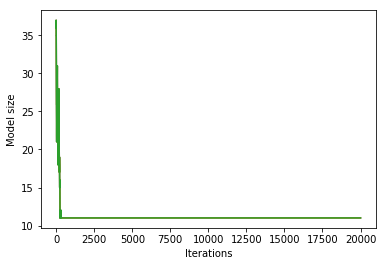

In [18]:
plt.plot(np.arange(data.shape[0]), np.count_nonzero(data, axis=1))
plt.xlabel("Iterations")
plt.ylabel("Model size")
plt.show()

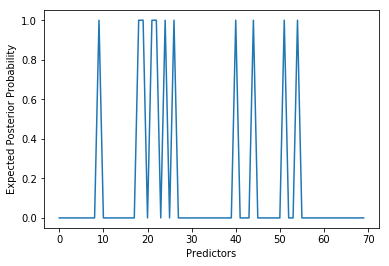

In [23]:
plt.plot(np.arange(data.shape[1]), data.mean(axis=0))
plt.xlabel("Predictors")
plt.ylabel("Expected Posterior Probability")
plt.show()

In [27]:
pd.DataFrame(data).assign(count=-1).groupby(list(range(70))).count()

count
0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69          
False False False False False False False False False True  False False False False False False False False True  False True  True  True  False True  False True  False False False False False False False False False False False False False True  False False False False False False False False False False True  False True  True  False False False False False False False False False False False False False False False      3
                                                                                                                  True  False True  True  False True  False True  False False False False False False False False False False False False False True  False False False False False False False False False False True  False True  True  False False False False False False False False False False False False False False False     40
                                                                                                                                                                                                                                                                        True  False False False False False False True  False False True  False False False False False False False False False False False False False False False  19688
                                                                                                                                                                                                                                                                                                                              True  True  False False False False False False False False False False False False False False False     14
                                                                                                                        True  True  True  False True  False True  False False False False False False False False False False False False False True  False False False False False False False False False False True  False True  True  False False False False False False False False False False False False False False False      1
                  True  False False False False False False False False False False False False True  False True  False False False True  False False False False False False False True  False False False False False True  False False False False False False False False True  False False True  True  False True  False True  False True  True  True  False False False True  False False True  True  False False False True       3
                                                                                                                                                                                                                                                                                                                                                                  True  False True  False False True  True  False False False True       2
                                                                                                                                                                                                                                                                                                                                                                                                            True  False False True       2
                                                      True  False False False False False False False False True  False True  True  True  False True  F

In [29]:
predicted_model = data.mean(axis=0) > 0.7
predicted_model.nonzero()

(array([ 9, 18, 19, 21, 22, 24, 26, 40, 44, 51, 54]),)